In [8]:
import logging, sys
import numpy as np
sys.path.insert(0, "../..")
import scirpy as ir
import scanpy as sc
from statistics import mean
from glob import glob
import pandas as pd
import tarfile
import anndata
import warnings
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from numba import NumbaPerformanceWarning


## Since we have debugged the code and know that everything works fine, we now supress all kinds of unwanted messages generated
## and only keep the printed or necessary results. This is for the purpose of better readability of the .pdf report generated.

import warnings
warnings.simplefilter('ignore')

logging.disable(sys.maxsize)
## ignore numba performance warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

## suppress "storing XXX as categorical" warnings.
anndata.logging.anndata_logger.setLevel("ERROR")

In [28]:
annotated = sc.read('/scratch/annotated_umap.h5ad')
genes_and_pseudotime = pd.read_csv('/scratch/genes_and_peudotime.txt',sep=' ')

In [75]:
diff_exp_genes = genes_and_pseudotime['genes']
pseudotime_cluster_order = [genes_and_pseudotime['order'].loc[i] for i in range(len(set(genes_and_pseudotime['order'])))]
pseudotime_ordered_clusters = [annotated[annotated.obs['leiden_number']==str(order)].obs['leiden'].iloc[1] for order in pseudotime_cluster_order]

In [76]:
cluster_centroid = {}
for cluster in set(annotated.obs['leiden']):
    cluster_centroid_x = mean(coord[0] for coord in annotated[annotated.obs['leiden']==cluster].obsm['X_umap'])
    cluster_centroid_y = mean(coord[1] for coord in annotated[annotated.obs['leiden']==cluster].obsm['X_umap'])
    cluster_centroid[cluster] = (cluster_centroid_x, cluster_centroid_y)

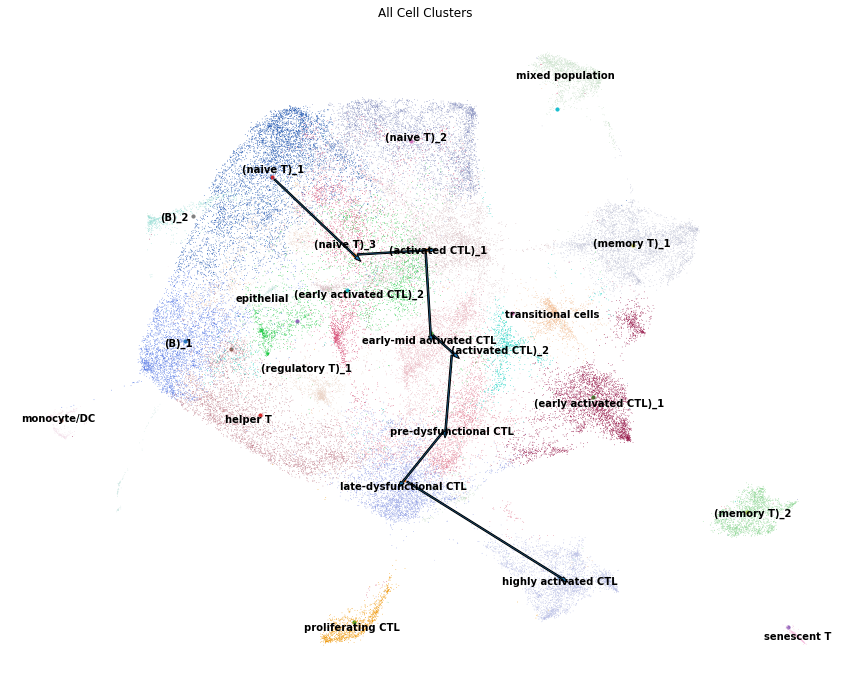

In [77]:
fig, ax = plt.subplots(figsize=(15,12))
for cluster in cluster_centroid:
    ax.scatter(cluster_centroid[cluster][0],cluster_centroid[cluster][1],s=10)
for i in range(len(pseudotime_cluster_order)-1):
    start_x, start_y = cluster_centroid[pseudotime_ordered_clusters[i]]
    end_x, end_y = cluster_centroid[pseudotime_ordered_clusters[i+1]]
    dx, dy = (end_x-start_x, end_y-start_y)
    ax.arrow(start_x, start_y, dx, dy,width=0.03, head_starts_at_zero=True)   
sc.pl.umap(annotated, color='leiden', title='All Cell Clusters', legend_loc='on data',frameon=False,ax=ax)

In [89]:
cells_of_interest = [False]*annotated.n_obs
for cluster in pseudotime_ordered_cluster:
    cluster_cells = annotated.obs['leiden']==cluster
    cells_of_interest |= cluster_cells
    
clusters_of_interest = annotated[cells_of_interest,]

In [100]:
clusters_of_interest.obs['leiden'].cat.reorder_categories(pseudotime_ordered_clusters, inplace = True)

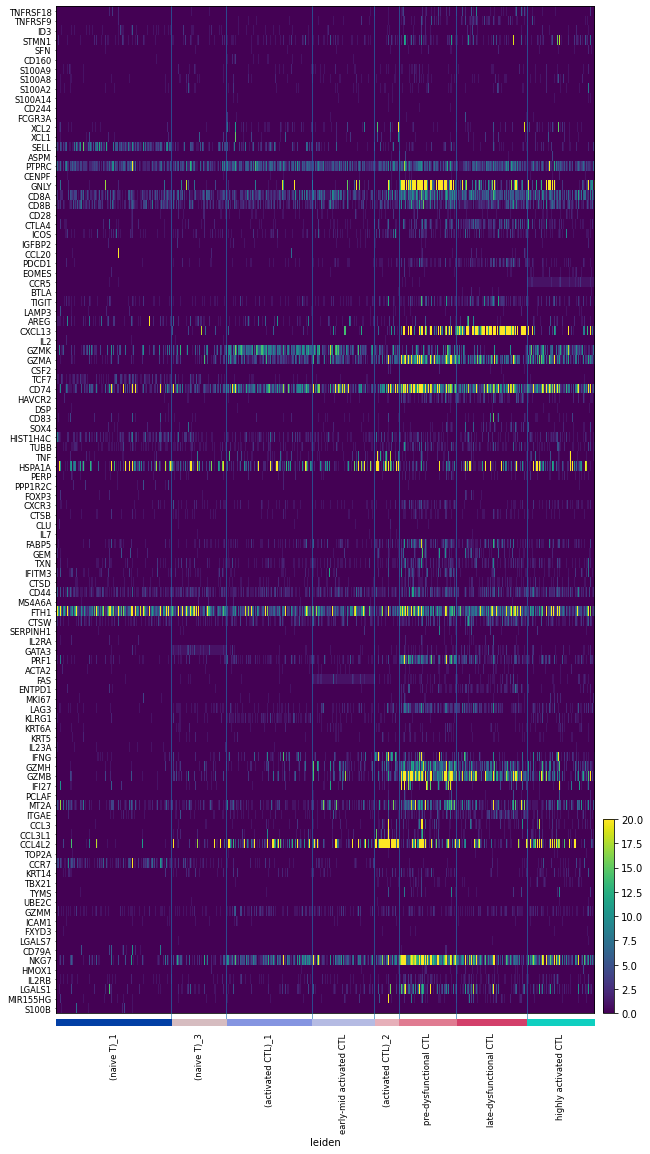

In [103]:
sc.pl.heatmap(clusters_of_interest, diff_exp_genes, groupby='leiden', show_gene_labels=True, swap_axes=True,vmax=20)